In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The igraph package provides utilities for analyzing and visualizing network graphs
import igraph as ig

### Load and visualize graph

In [4]:
def load_adjacency_list(path, v_e_sep=':', e_sep=' '):
    adj_list = None
    with open(path, 'r') as f:
        adj_list = {}
        for line in f:
            if v_e_sep in line:
                v1, edges = line.split(v_e_sep)
                v1 = v1
                adj_list[v1] = []
                for v2 in edges.split(e_sep):
                    v2 = v2.strip()
                    if len(v2) > 0:
                        adj_list[v1].append(v2)
    return adj_list

In [35]:
8424 / 238

35.39495798319328

In [5]:
adj_list = load_adjacency_list('egonet_graph.txt')

In [6]:
vertices = list(adj_list.keys())

In [7]:
edges = []
for i1, v1 in enumerate(vertices):
    for v2 in adj_list[v1]:
        i2 = vertices.index(v2)
        edges.append((i1, i2))

The `igraph.Graph.layout('kk', dim=n)` method implements the Kamada-Kawai algorithm for drawing undirected graphs in a way that helps to visualize their topology. It does this by connecting users with "springs" for edges, and minimizing the total energy of the spring network, which determines their position and separation in `n` dimensions. See https://pdfs.semanticscholar.org/b8d3/bca50ccc573c5cb99f7d201e8acce6618f04.pdf.

In [8]:
G = ig.Graph(edges=edges, directed=False)
G_layout = G.layout('kk', dim=2)

In [10]:
N = len(vertices)
Xn=[G_layout[k][0] for k in range(N)] # x-coordinates of nodes
Yn=[G_layout[k][1] for k in range(N)] # y-coordinates
Xe=[]
Ye=[]
for e in edges:
    # Edge ends; NaN disconnects edges
    Xe += [G_layout[e[0]][0], G_layout[e[1]][0], np.nan] 
    Ye += [G_layout[e[0]][1], G_layout[e[1]][1], np.nan]

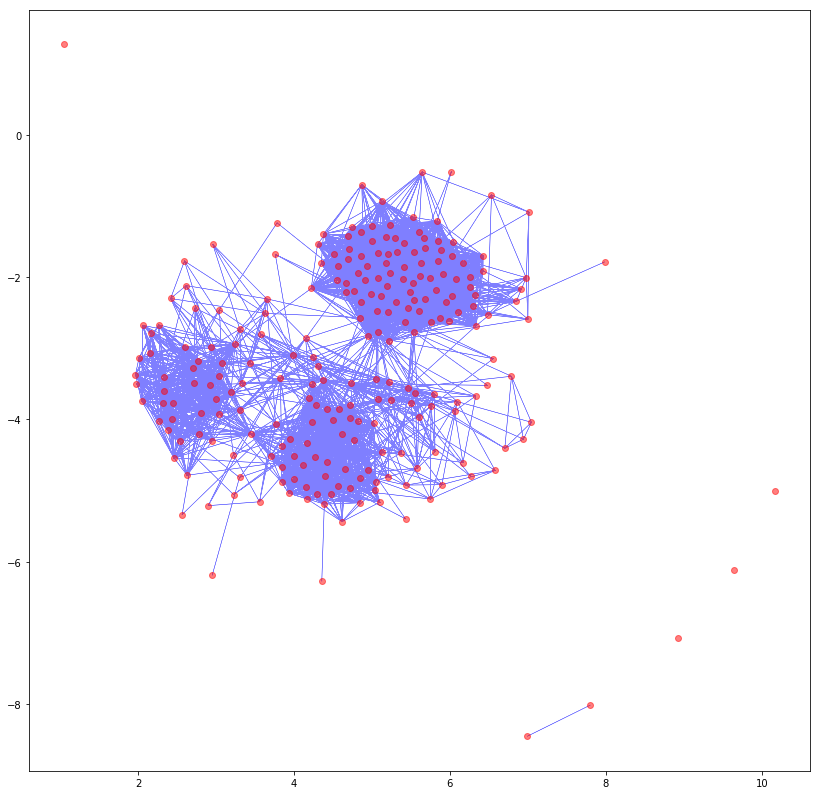

In [11]:
fig = plt.figure(figsize=(14,14))
lines = plt.plot(Xe, Ye, 'b-', linewidth=0.5, alpha=0.5)
pts = plt.plot(Xn, Yn, 'ro', alpha=0.5)

We can see three visible "clusters" of users. Also note that a handful of users are either completely disconnected, or in one case, only connected to one other user. I really should have removed these users before giving you the graph, probably...

### Stats on edges

In [12]:
sum(edge_counts)

8420

In [13]:
len(edges)

8420

In [9]:
edge_counts = np.array([len(e) for e in adj_list.values()])
edge_stats = {}
edge_stats['min'] = np.min(edge_counts)
edge_stats['max'] = np.max(edge_counts)
edge_stats['mean'] = np.mean(edge_counts)
edge_stats['median'] = np.median(edge_counts)
print(edge_stats)

{'median': 31.5, 'max': 92, 'min': 0, 'mean': 35.378151260504204}


In [10]:
edge_counts.shape

(238,)

### Stats on shortest distances between edge pairs

In [96]:
def load_matrix(path, INF='inf', dtype=float):
    dist_mat = None
    with open(path, 'r') as f:
        dist_mat = []
        for line in f:
            dist_line = []
            for v in line.split(' '):
                if v.lower() == INF:
                    dist_line.append(np.nan)
                else:
                    try:
                        dist_line.append(dtype(v))
                    except ValueError:
                        continue
            dist_mat.append(dist_line)
        dist_mat = np.array(dist_mat)
    return dist_mat

In [97]:
dist_mat = load_matrix('egonet0_dist_mat.out')
print('Loaded {} distance matrix'.format(dist_mat.shape))

Loaded (238, 238) distance matrix


In [98]:
pair_dists = dist_mat[np.tril_indices(len(dist_mat), -1)]

Because some vertices/users are not connected to any others (and two users only connected to each other), there are some `INF` values in the distance matrix. These were converted to `np.nan` in the `load_matrix()` function, and the `np.nan*()` versions of the stats functions are used below to ignore these infinite distance values.

In [102]:
dist_stats = {}
dist_stats['min'] = np.nanmin(pair_dists)
dist_stats['max'] = np.nanmax(pair_dists)
dist_stats['mean'] = np.nanmean(pair_dists)
dist_stats['median'] = np.nanmedian(pair_dists)
print(dist_stats)

{'min': 1.0, 'median': 3.0, 'mean': 2.468186737321342, 'max': 6.0}


### Components in graph

Output of the compiled program on the test graph and the egonet graph:

```
$ g++ -o hw5.exe hw5.cpp
$ ./hw5.exe
Testing ./hw5.exe ...


Nodes:
A B C D E F G H I J 

Edges:
A: B C D 
B: A E F 
C: A F 
D: A G H 
E: B I J 
F: B C 
G: D H 
H: D G 
I: E J 
J: E I 

In egonet graph with 10 vertices and 24 edges, found 1 components

Distance matrix:
0 1 1 1 2 2 2 2 3 3 
1 0 2 2 1 1 3 3 2 2 
1 2 0 2 3 1 3 3 4 4 
1 2 2 0 3 3 1 1 4 4 
2 1 3 3 0 2 4 4 1 1 
2 1 1 3 2 0 4 4 3 3 
2 3 3 1 4 4 0 1 5 5 
2 3 3 1 4 4 1 0 5 5 
3 2 4 4 1 3 5 5 0 1 
3 2 4 4 1 3 5 5 1 0 

$ ./hw5.exe egonet_graph.txt egonet0_dist_mat.out
In egonet graph with 238 vertices and 8424 edges, found 6 components

Writing distance matrix to egonet0_dist_mat.out
```